In [99]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from attention import Attention

In [100]:
df=pd.read_csv('datos/airline-passengers.csv')
print("El conjunto de datos tiene {} filas y {} columnas.".format(*df.shape))
df.head()

El conjunto de datos tiene 144 filas y 2 columnas.


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [102]:
df['Month'] = pd.to_datetime(df['Month'], format="%Y-%m")
df.head(1)


,Month,Passengers
0,1949-01-01,112


In [103]:
df=df.rename(columns={'Month':'Date'})
df.head(1)

,Date,Passengers
0,1949-01-01,112


In [104]:
df["Month"] = df['Date'].apply(lambda x: x.month)
df["Year"] = df['Date'].apply(lambda x: x.year)
df.head()

,Date,Passengers,Month,Year
0,1949-01-01,112,1,1949
1,1949-02-01,118,2,1949
2,1949-03-01,132,3,1949
3,1949-04-01,129,4,1949
4,1949-05-01,121,5,1949


In [105]:
df = df.set_index('Date')
df.head(1)

,Passengers,Month,Year
Date,,,
1949-01-01,112,1,1949


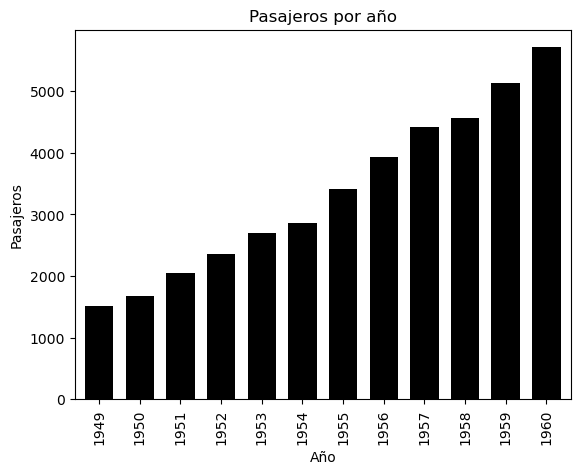

In [106]:
plt.figure()
data = df.groupby("Year")["Passengers"] .sum()
data.plot.bar(title = 'Pasajeros por año', color='black', width = 0.7, linewidth = 0.5)
plt.xlabel('Año')
plt.ylabel('Pasajeros')
plt.show()

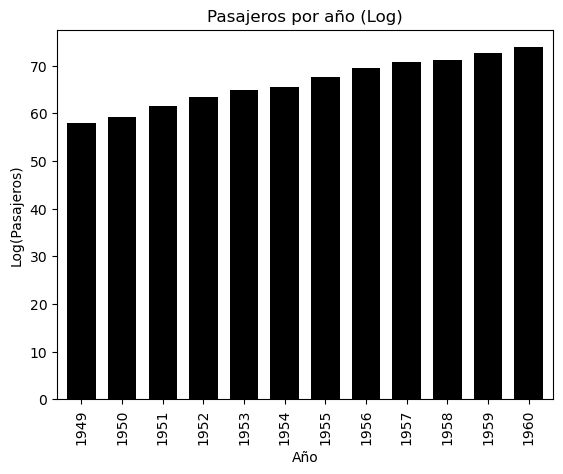

In [107]:
df['Passengers_Log']=np.log(df['Passengers'])
figure = plt.figure()
data = df.groupby("Year")["Passengers_Log"].sum()
data.plot.bar(title = 'Pasajeros por año (Log)', color='black', width = 0.7,
linewidth = 0.5)
plt.xlabel('Año')
plt.ylabel('Log(Pasajeros)')
plt.show()

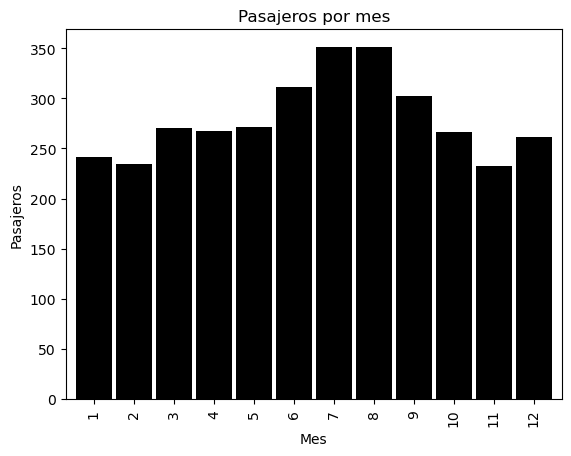

In [108]:
figure = plt.figure()
data = df.groupby("Month")["Passengers"].mean()
data.plot.bar(title = 'Pasajeros por mes', color='black', width=0.9)
plt.xlabel('Mes')
plt.ylabel('Pasajeros')
plt.show()

In [109]:
data_train=df.Passengers_Log[:116]
data_val=df.Passengers_Log[116:130]
data_test=df.Passengers_Log[130:]
data_train.index = pd.DatetimeIndex(data_train.index.values, freq='MS')
data_val.index = pd.DatetimeIndex(data_val.index.values, freq='MS')
data_test.index = pd.DatetimeIndex(data_test.index.values, freq='MS')

In [110]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_train, model='additive')

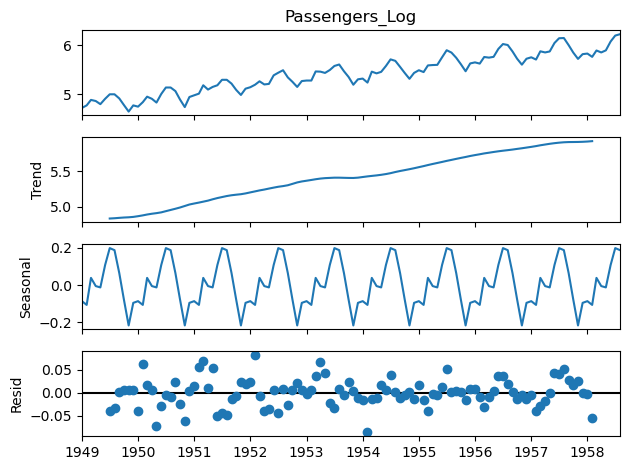

In [111]:
decomposition.plot()
plt. show()

In [112]:
pas_log_D = data_train.diff(12).dropna()

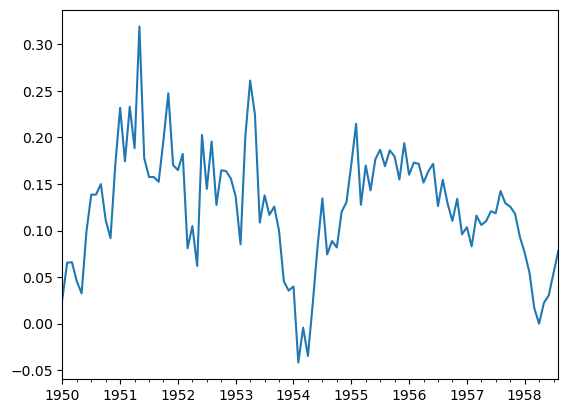

In [113]:
pas_log_D.plot()
plt. show()

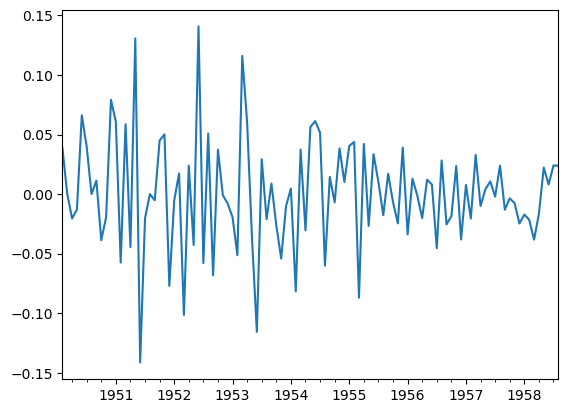

In [114]:
pas_log_D_d = pas_log_D.diff(1).dropna()
pas_log_D_d.plot()
plt. show()

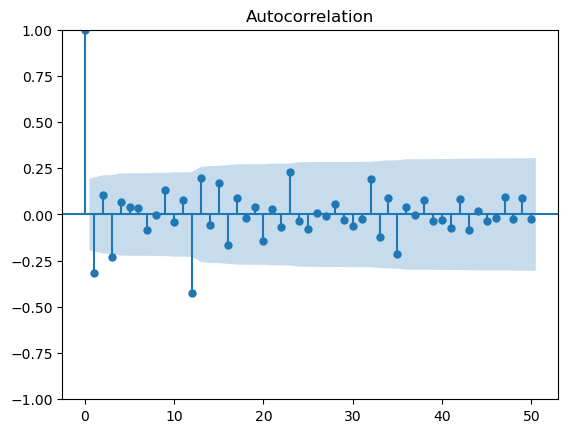

In [115]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(pas_log_D_d, lags=50)
plt. show()

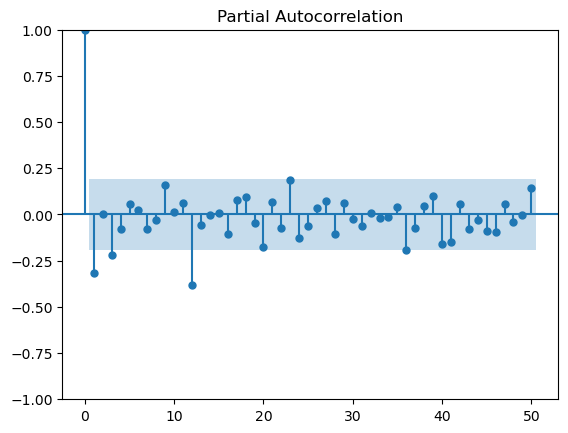

In [116]:
plot_pacf(pas_log_D_d, lags=50, method='ywm')
plt. show()

In [117]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
mod = SARIMAX(data_train,
order=(1,1,1),
seasonal_order=(0,1,1,12),
enforce_stationarity=False,
enforce_invertibility=False)

results = mod.fit(maxiter=200, method='powell')
print('AIC:{}'.format(results.aic))

Optimization terminated successfully.
         Current function value: -1.438483
         Iterations: 3
         Function evaluations: 147
AIC:-325.72795902315534


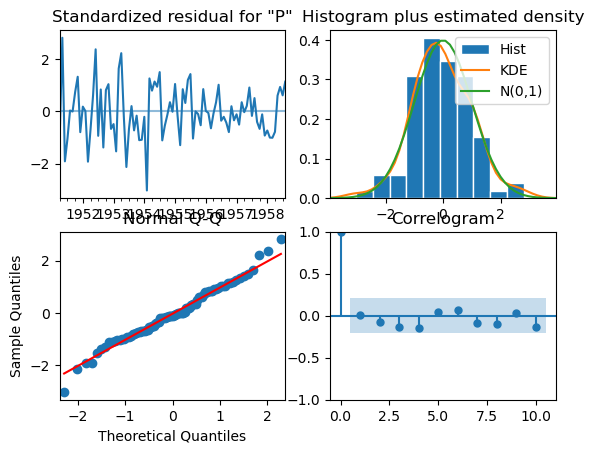

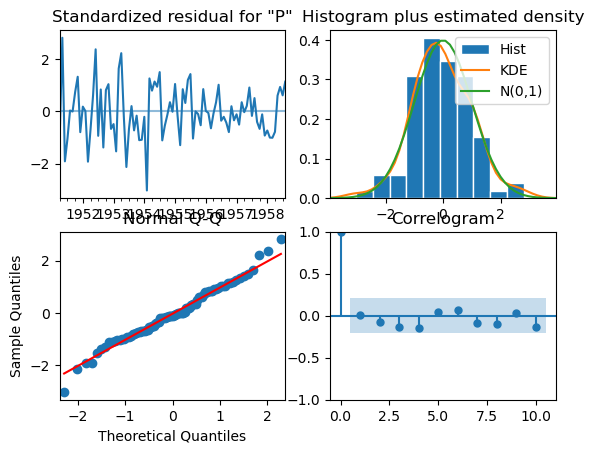

In [118]:
results.plot_diagnostics()

In [119]:
def plot_results(Y_train, Y_val, Y_test, pred_train, pred_val, pred_test):
    plt.figure(figsize=(12, 6))  # optional for better readability
    
    Y_tot = np.concatenate([Y_train, Y_val, Y_test])
    pred_tot = np.concatenate([pred_train, pred_val, pred_test])

    plt.plot(Y_tot, 'k-', label="True")
    plt.plot(pred_tot, 'r-', label="Pred", alpha=0.6)

    ax = plt.gca()
    ylims = ax.get_ylim()
    legend_handles, legend_labels = ax.get_legend_handles_labels()

    # Fix: ymax was using ylims[l] (l is an axis object, not index)
    plt.vlines(len(Y_train), ymin=ylims[0], ymax=ylims[1], linestyle='--', color='k')
    plt.vlines(len(Y_train) + len(Y_val), ymin=ylims[0], ymax=ylims[1], linestyle='--', color='k')

    # Fix: 'xl' should be 'x1', and use consistent args
    train_bg = plt.fill_betweenx(ylims, x1=0, x2=len(Y_train), color='k', alpha=0.1)
    val_bg = plt.fill_betweenx(ylims, x1=len(Y_train), x2=len(Y_train)+len(Y_val), color='k', alpha=0.2)
    test_bg = plt.fill_betweenx(ylims, x1=len(Y_train)+len(Y_val), x2=len(Y_train)+len(Y_val)+len(Y_test), color='k', alpha=0.3)

    legend_handles.extend([train_bg, val_bg, test_bg])
    legend_labels.extend(["Train", "Validation", "Test"])

    plt.legend(legend_handles, legend_labels)
    plt.title("SARIMA(?,1,?)x(0,1,1,12)")  # Replace ? with actual SARIMA params
    plt.xlabel("Time")
    plt.ylabel("Value")

    plt.tight_layout()
    plt.show()

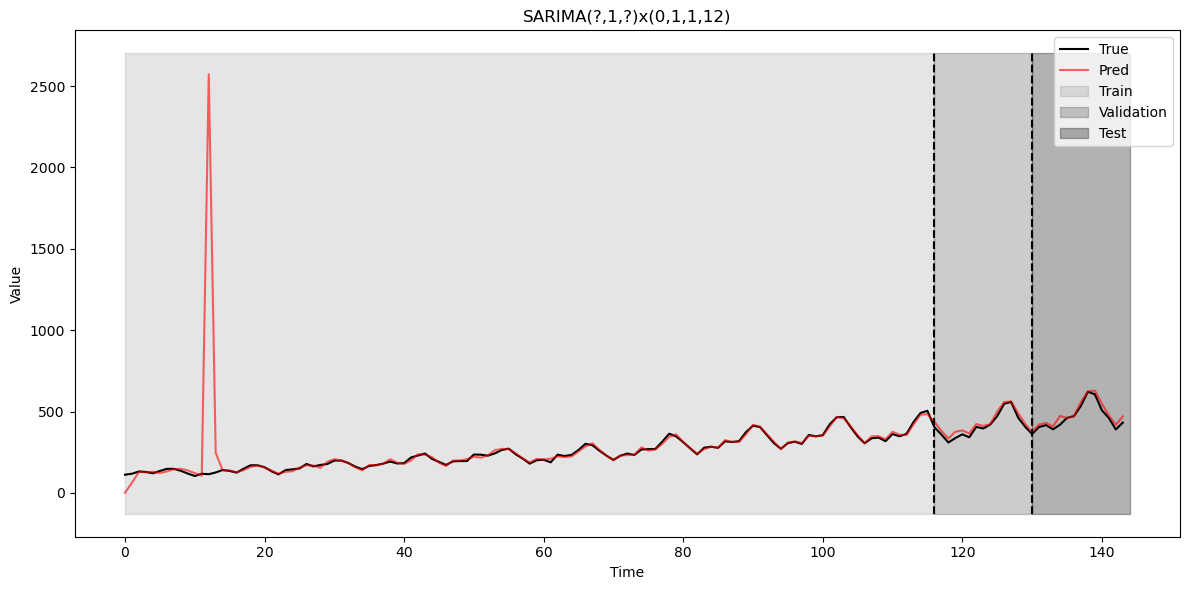

In [120]:
# Predictions (assuming results and data_* are defined)
pred_train = results.get_prediction(start=data_train.index[0], end=data_train.index[-1]).predicted_mean
pred_val = results.get_prediction(start=data_val.index[0], end=data_val.index[-1]).predicted_mean
pred_test = results.get_prediction(start=data_test.index[0], end=data_test.index[-1]).predicted_mean

# Convert from log scale if necessary
pred_train_o = np.exp(pred_train)
pred_val_o = np.exp(pred_val)
pred_test_o = np.exp(pred_test)

# Plot using observed + predicted values
plot_results(np.exp(data_train.values), np.exp(data_val.values), np.exp(data_test.values),
             pred_train_o.values, pred_val_o.values, pred_test_o.values)

In [121]:
rmse_val = np.sqrt(mean_squared_error(np.exp(data_val), pred_val_o))
rmse_test = np.sqrt(mean_squared_error(np.exp(data_test), pred_test_o))
print(f"[Validation] RMSE: {rmse_val: .3f} 1 [Test] RMSE: {rmse_test: .3f}")

[Validation] RMSE:  22.908 1 [Test] RMSE:  25.326


In [122]:
transf_min = data_train.min()
transf_max = data_train.max()
data_train_scaled = (data_train - transf_min) / (transf_max-transf_min)
data_val_scaled = (data_val - transf_min) / (transf_max-transf_min)
data_test_scaled = (data_test - transf_min) / (transf_max-transf_min)

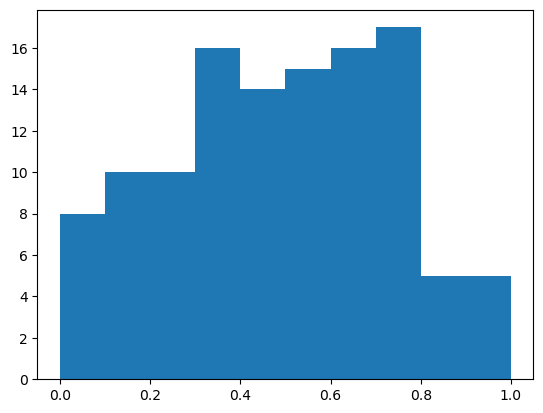

In [123]:
plt. figure()
plt.hist(data_train_scaled)
plt. show()

In [124]:
def create_dataset(ts, lag=1, pred_len=1):
    ## Creamos dos listas vacías que llenaremos con las ventanas
    X, Y = [], []
    ## Creamos un índice con el que recorrer la serie temporal
    ## el +1 final es necesario para coger el último elemento
    ## porque Python no coge el elemento b al hacer [a:b]
    for i in range(len(ts)-lag-pred_len+1):
        X.append(ts[i:i+lag])
        Y.append(ts[i+lag:i+lag+pred_len])
    return np.array(X), np.array(Y)

In [125]:
test = np.arange(15)
X, Y = create_dataset(test, lag=7, pred_len=1)
for a, b in zip(X, Y):
    print(f"X: {a} 1 Y: {b}")

X: [0 1 2 3 4 5 6] 1 Y: [7]
X: [1 2 3 4 5 6 7] 1 Y: [8]
X: [2 3 4 5 6 7 8] 1 Y: [9]
X: [3 4 5 6 7 8 9] 1 Y: [10]
X: [ 4  5  6  7  8  9 10] 1 Y: [11]
X: [ 5  6  7  8  9 10 11] 1 Y: [12]
X: [ 6  7  8  9 10 11 12] 1 Y: [13]
X: [ 7  8  9 10 11 12 13] 1 Y: [14]


In [126]:
lag = 7
pred_len = 1
X_train, Y_train = create_dataset(data_train_scaled, lag=lag, pred_len=pred_len)
X_val, Y_val = create_dataset(data_val_scaled, lag=lag, pred_len=pred_len)
X_test, Y_test = create_dataset(data_test_scaled, lag=lag, pred_len=pred_len)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((109, 7), (109, 1), (7, 7), (7, 1), (7, 7), (7, 1))

In [127]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((109, 7, 1), (109, 1), (7, 7, 1), (7, 1), (7, 7, 1), (7, 1))

In [128]:
def train_model(model,
X_train, Y_train,
X_val, Y_val,
epochs=100, verbose=1):
    model.compile(loss="mean_squared_error",
    optimizer="adam",
    metrics=["mae"])
    history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val,
    Y_val), verbose=verbose)
    return history

In [129]:
def inverse_transform(X, max, min):
    X = X*(max-min)+min
    return np.exp(X)

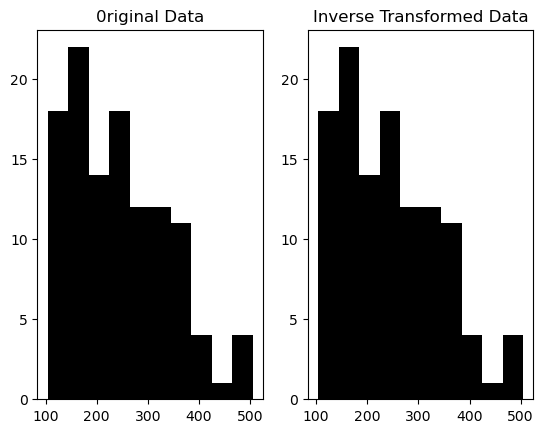

In [130]:
original_data_train = inverse_transform(data_train_scaled, transf_max,
transf_min)
plt.figure()
plt.subplot(1,2,1)
plt.title("0riginal Data")
plt.hist(df.Passengers[:116], color='k')
plt.subplot(1,2,2)
plt.title("Inverse Transformed Data")
plt.hist(original_data_train, color='k')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.metrics import mean_squared_error
import pandas as pd

# ---------------------------
# FUNCIONES UTILITARIAS
# ---------------------------

def inverse_transform(data, max_val, min_val):
    return data * (max_val - min_val) + min_val

def train_model(model, X_train, Y_train, X_val, Y_val, epochs=100, verbose=1):
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mae"])
    history = model.fit(X_train, Y_train, epochs=epochs,
                        validation_data=(X_val, Y_val), verbose=verbose)
    return history

def evaluate_model(model, X_train, Y_train, X_val, Y_val, X_test, Y_test, max_val, min_val, verbose=False, plot=False):
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)

    # Invertir transformaciones
    pred_train = inverse_transform(pred_train, max_val, min_val)
    Y_train_o = inverse_transform(Y_train, max_val, min_val)
    pred_val = inverse_transform(pred_val, max_val, min_val)
    Y_val_o = inverse_transform(Y_val, max_val, min_val)
    pred_test = inverse_transform(pred_test, max_val, min_val)
    Y_test_o = inverse_transform(Y_test, max_val, min_val)

    # RMSE
    score_train = np.sqrt(mean_squared_error(Y_train_o, pred_train))
    score_val = np.sqrt(mean_squared_error(Y_val_o, pred_val))
    score_test = np.sqrt(mean_squared_error(Y_test_o, pred_test))

    if verbose:
        print(f"[Train] RMSE: {score_train:.2f} | [Validation] RMSE: {score_val:.2f} | [Test] RMSE: {score_test:.2f}")

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(Y_test_o, label='Real', linewidth=2)
        plt.plot(pred_test, label='Predicho', linestyle='--')
        plt.legend()
        plt.title("Predicción en Test")

    return score_train, score_val, score_test

def build_lstm_attention_model(lag):
    inputs = Input(shape=(lag, 1))
    lstm_out = layers.LSTM(16, return_sequences=True)(inputs)
    attn_out = layers.Attention()([lstm_out, lstm_out])
    context_vector = tf.keras.layers.GlobalAveragePooling1D()(attn_out)
    dense = layers.Dense(16, activation='relu')(context_vector)
    output = layers.Dense(1)(dense)
    return Model(inputs=inputs, outputs=output)

# ---------------------------
# MODELOS
# ---------------------------

lag = 7  # Tu valor de ventana de tiempo

model_rnn = tf.keras.Sequential([
    layers.SimpleRNN(120, input_shape=(lag, 1)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model_lstm = tf.keras.Sequential([
    layers.LSTM(16, input_shape=(lag, 1)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model_gru = tf.keras.Sequential([
    layers.GRU(16, input_shape=(lag, 1)),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model_attention = build_lstm_attention_model(lag)

models = {
    "RNN": model_rnn,
    "LSTM": model_lstm,
    "GRU": model_gru,
    "LSTM+Attention": model_attention
}

# ---------------------------
# RESULTADOS
# ---------------------------

# Asegúrate de que estos valores estén definidos previamente:
# rmse_val, rmse_test = resultados de SARIMA ya transformados a escala original
results = {
    "Model": ["SARIMA"],
    "Train_RMSE": [np.nan],
    "Validation_RMSE": [rmse_val],
    "Test_RMSE": [rmse_test]
}

# ---------------------------
# ENTRENAMIENTO Y EVALUACIÓN
# ---------------------------

for model_name, model in models.items():
    print(f"\n➡️ Entrenando modelo: {model_name}")
    train_model(model, X_train, Y_train, X_val, Y_val, epochs=100, verbose=0)

    rmse_train, rmse_val, rmse_test = evaluate_model(
        model, X_train, Y_train, X_val, Y_val, X_test, Y_test,
        transf_max, transf_min,
        plot=True
    )
    plt.title(model_name)
    plt.show()

    results["Model"].append(model_name)
    results["Train_RMSE"].append(rmse_train)
    results["Validation_RMSE"].append(rmse_val)
    results["Test_RMSE"].append(rmse_test)

# ---------------------------
# VISUALIZAR RESULTADOS
# ---------------------------
df_results = pd.DataFrame(results)
print("\n📊 RESULTADOS FINALES:\n")
print(df_results)


In [132]:
df_results = pd.DataFrame(results).set_index("Model")
df_results

,Train_RMSE,Validation_RMSE,Test_RMSE
Model,,,
SARIMA,NaN,22.908197,25.325884
RNN,0.094708,0.109811,0.113439
LSTM,0.138513,0.182555,0.197254
GRU,0.124817,0.147903,0.159302
LSTM+Attention,0.179403,0.241943,0.250217
